<a href="https://colab.research.google.com/github/georgeputhean/garbageclassificationPytorch/blob/main/DMPA_Garbage_Prediction_Project_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
import torchvision.models as models
import torch
import torchvision
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [ ]:
#mounting the drive to load the garbage data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path of the images in the google drive
path  = r'/content/drive/Shareddrives/DMPA Project/Garbage classification'
labels = os.listdir(path)
print(labels)

['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash']


In [ ]:
#tranforming the image 
transformationgenerator = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
garbage_data = ImageFolder(path, transform = transformationgenerator)

In [ ]:
#plotting an image to find if the data is read
import matplotlib.pyplot as plt
%matplotlib inline
#function to read image and label
def plot_image(img, label):
    print("Class : ", garbage_data.classes[label], " Class =  "+ str(label))
    plt.imshow(img.permute(1, 2, 0))

Class :  cardboard  Class =  0


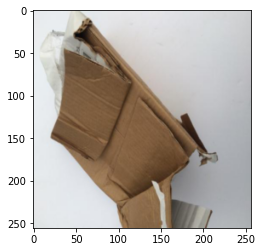

In [ ]:
#plotting an image
img, label = garbage_data[97]
plot_image(img, label)

In [ ]:
#splitting the data in train , test and validation
torch.manual_seed(65)
train_data, validation_data, test_data = random_split(garbage_data, [1900, 256, 371])
len(train_data), len(validation_data), len(test_data)

(1900, 256, 371)

In [ ]:
#Training and Validation Data Generator/Loader
batch_size = 48
train_dataloader = DataLoader(train_data, batch_size, shuffle = True, pin_memory = True)
validation_dataloader = DataLoader(validation_data, batch_size*2, pin_memory = True)

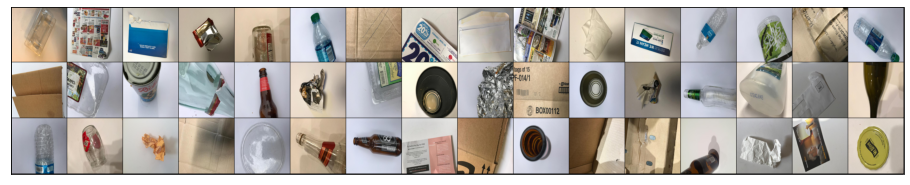

In [ ]:
#Plot images on batch in a grid
from torchvision.utils import make_grid

def plot_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break
plot_batch(train_dataloader)

In [ ]:
#source
#https://colab.research.google.com/github/divya-r-kamat/PyTorch/blob/master/MNIST_CNN_(Fine_Tuning).ipynb#scrollTo=hu3hdE5xDIuf
#https://medium.com/analytics-vidhya/image-classification-with-pytorch-184e76c2cf3b
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#https://pytorch.org/hub/pytorch_vision_resnet/
#source
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(garbage_data.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

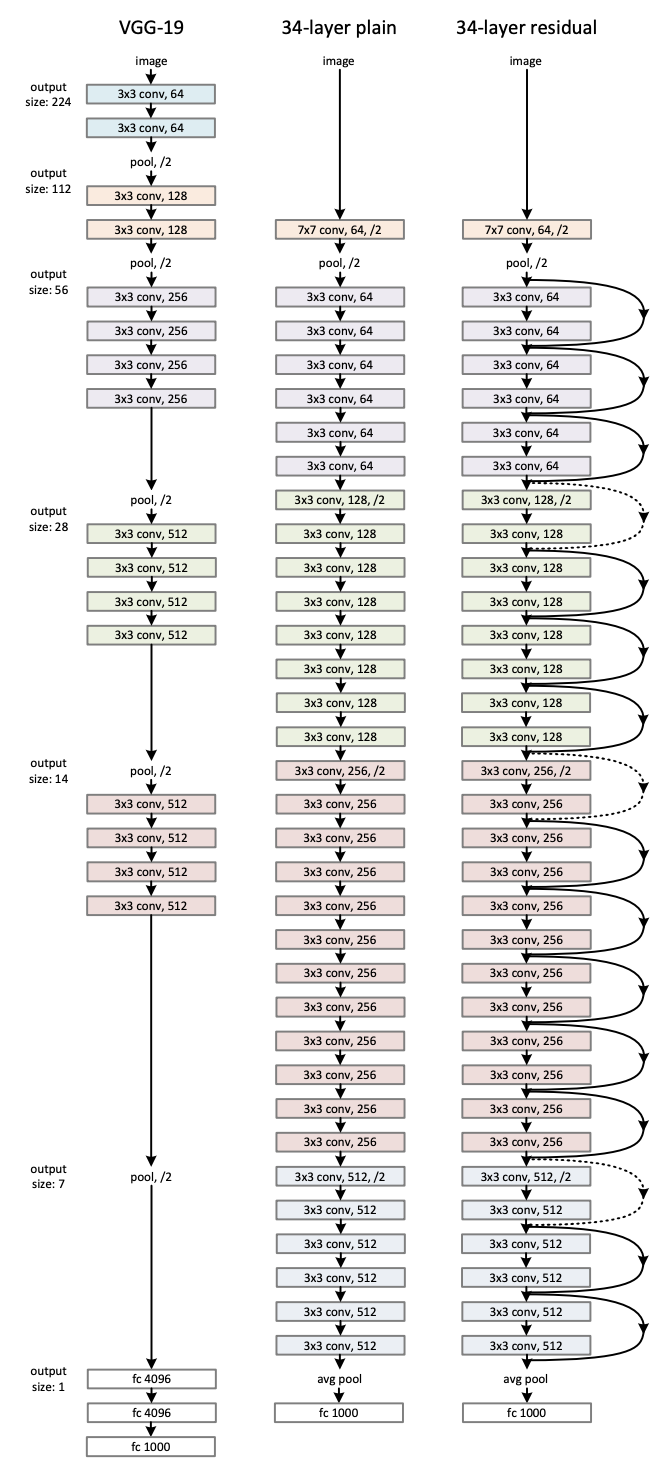






In [ ]:
#https://discuss.pytorch.org/t/pytorch-keeps-using-cpu-instead-of-gpu/131690


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, validation_dataloader)

{'val_acc': 0.1927083283662796, 'val_loss': 1.8006914854049683}

In [ ]:
num_epochs = 20

opt_func = torch.optim.Adam

lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func)

Epoch 1: train_loss: 1.4497, val_loss: 1.2819, val_acc: 0.8003
Epoch 2: train_loss: 1.2033, val_loss: 1.1772, val_acc: 0.9201
Epoch 3: train_loss: 1.1108, val_loss: 1.1353, val_acc: 0.9306
Epoch 4: train_loss: 1.0763, val_loss: 1.1265, val_acc: 0.9427
Epoch 5: train_loss: 1.0632, val_loss: 1.1187, val_acc: 0.9410
Epoch 6: train_loss: 1.0577, val_loss: 1.1214, val_acc: 0.9271
Epoch 7: train_loss: 1.0546, val_loss: 1.1164, val_acc: 0.9358
Epoch 8: train_loss: 1.0529, val_loss: 1.1181, val_acc: 0.9358
Epoch 9: train_loss: 1.0512, val_loss: 1.1112, val_acc: 0.9392
Epoch 10: train_loss: 1.0501, val_loss: 1.1136, val_acc: 0.9392
Epoch 11: train_loss: 1.0527, val_loss: 1.1186, val_acc: 0.9444
Epoch 12: train_loss: 1.0527, val_loss: 1.1097, val_acc: 0.9427
Epoch 13: train_loss: 1.0511, val_loss: 1.1115, val_acc: 0.9427
Epoch 14: train_loss: 1.0519, val_loss: 1.1149, val_acc: 0.9323
Epoch 15: train_loss: 1.0490, val_loss: 1.1182, val_acc: 0.9288
Epoch 16: train_loss: 1.0494, val_loss: 1.1114, v

In [ ]:
PATH = "entire_model.pt"

# Save
torch.save(model, PATH)


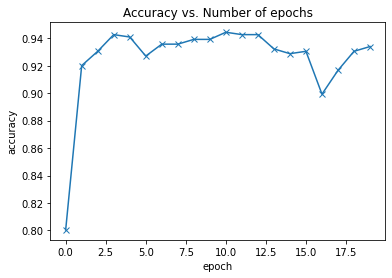

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. Number of epochs');

plot_accuracies(history)



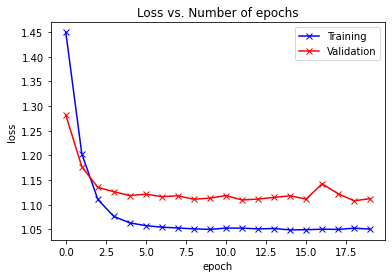

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

plot_losses(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return garbage_data.classes[preds[0].item()]

Label: paper , Predicted: paper


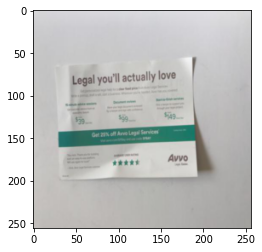

In [ ]:
img, label = test_data[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', garbage_data.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: metal


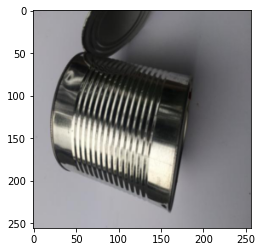

In [ ]:
img, label = test_data[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', garbage_data.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


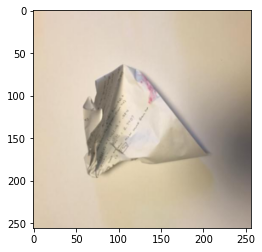

In [ ]:
img, label = test_data[49]
plt.imshow(img.permute(1, 2, 0))
print('Label:', garbage_data.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://wastemanagementreview.com.au/wp-content/uploads/2019/05/bottle.jpg", "plastic.jpg")
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fi.ebayimg.com%2Fimages%2Fi%2F291536274730-0-1%2Fs-l1000.jpg&f=1&nofb=1", "cardboard.jpg") 
urllib.request.urlretrieve("https://img.uline.com/is/image/uline/S-4122?$MediumRHD$", "cardboard2.jpg") 
    
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.2F0uH6BguQMctAYEJ-s-1gHaHb%26pid%3DApi&f=1", "cans.jpg") 
urllib.request.urlretrieve("https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftinytrashcan.com%2Fwp-content%2Fuploads%2F2018%2F08%2Ftiny-trash-can-bulk-wine-bottle.jpg&f=1&nofb=1", "wine-trash.jpg")
urllib.request.urlretrieve("http://ourauckland.aucklandcouncil.govt.nz/media/7418/38-94320.jpg", "paper-trash.jpg")

('paper-trash.jpg', <http.client.HTTPMessage at 0x7fa8de4d1610>)

In [ ]:
model = torch.load('New_model_0508221845.pt')

FileNotFoundError: ignored

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, model) + ".")

In [ ]:
predict_external_image('cans.jpg')

In [ ]:
predict_external_image('cardboard.jpg')

In [ ]:
predict_external_image('plastic.jpg')

In [ ]:
predict_external_image('wine-trash.jpg')

In [ ]:
len(test_data)

In [ ]:
def predict_imageprob(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return (prob[0].item())

In [ ]:
dfx=[]
for i in range(len(test_data)):
  dfx.append(test_data[i][1])
print(dfx)

In [ ]:
def predict_imageprob(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return (preds[0].item())

In [ ]:
gain_pred=predict_imageprob(img, model)
print(gain_pred)

In [ ]:
gain_predappend=[]
j=0
for img,_ in test_data:
  gain_pred = predict_imageprob(img, model)
  gain_predappend.append(gain_pred)
  j=j+1
  

In [ ]:
# The usual train-test split mumbo-jumbo

from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(dfx, gain_predappend)
cm_df = pd.DataFrame(cm,
                     index = ['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash'], 
                     columns = ['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash'])

In [ ]:
import seaborn as sns
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap= 'Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [ ]:
ind= [0,1,2,3,4,5]
ind

In [ ]:
list(pd.DataFrame(dfx).value_counts())

In [ ]:
plt.bar(['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash'], list(pd.DataFrame(dfx).value_counts()), color ='maroon',
        width = 0.4)

In [ ]:
plt.bar(['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash'], list(pd.DataFrame(gain_predappend).value_counts()), color ='blue',
        width = 0.4)

In [ ]:
list(pd.DataFrame(gain_predappend).value_counts())

In [ ]:
list(pd.DataFrame(dfx).value_counts())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['glass', 'paper', 'plastic', 'metal', 'cardboard', 'trash']
actuals = [84, 79, 73, 61, 56, 18]
predictions = [86, 82, 64, 63, 61, 15]

# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
df = pd.DataFrame({'Actuals': actuals,
                    'Predictions': predictions}, index=labels)
ax = df.plot.bar(rot=0, color={"Actuals": "green", "Predictions": "blue"})